In [1]:
"""
    Dataset (Bangla ( Bengali ) sentiment analysis classification benchmark dataset corpus) : https://data.mendeley.com/datasets/p6zc7krs37/4
"""
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import pandas as pd
import string
import numpy as np
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import *
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import *
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from sklearn import preprocessing
from tensorflow.keras import mixed_precision
import tensorflow as tf
tf.keras.mixed_precision.experimental.Policy('mixed_float16')
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler
from keras.regularizers import l2

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660, compute capability 7.5


In [2]:
lstm_units = 50
w_decay = 0.05
dropout_rate = 0.2
epochs_to_run = 500
sequence_length = 200

In [3]:
# Loading Bangla ( Bengali ) sentiment analysis classification benchmark dataset
positive_sentences = []
f = open('../datasets/all_positive_8500.txt','r', encoding = 'utf-8')
for line in f:
    positive_sentences.append(line.strip())

negative_sentences = []
f = open('../datasets/all_negative_3307.txt','r', encoding = 'utf-8')
for line in f:
    negative_sentences.append(line.strip())
    
print(len(positive_sentences), 'positive sentences')
print(len(negative_sentences), 'negative sentences')

import random
random.shuffle(positive_sentences)

for i in range(len(positive_sentences)-len(negative_sentences)):
    positive_sentences.pop(0)

print(len(positive_sentences), 'positive sentences')
print(len(negative_sentences), 'negative sentences')


y_pos = [1 for i in range(len(positive_sentences))]
y_neg = [0 for i in range(len(negative_sentences))]

X = positive_sentences + negative_sentences
y = y_pos + y_neg

8500 positive sentences
3307 negative sentences
3307 positive sentences
3307 negative sentences


In [4]:
w2v_model = Word2Vec.load("word2vec.model")
words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print(vocab_size)

141148


In [5]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X)
y = np.array(y)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, sequence_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train_val = X_train
y_train_val = y_train

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_val, test_size=0.2, random_state=1, stratify=y_train_val)



In [6]:
from tensorflow.keras.layers import Embedding
def gensim_to_keras_embedding(model, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    keyed_vectors = model.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer

In [7]:
def ms_lstm(w2v):
    inputs = Input(shape=(X_train[0].shape[-1],))

    embedding_layer = gensim_to_keras_embedding(w2v)
    
    embedding = embedding_layer(inputs)

    lstm1 = LSTM(lstm_units,return_sequences=True, return_state=True, kernel_regularizer=l2(w_decay),recurrent_regularizer=l2(w_decay), dropout=dropout_rate)(embedding)
    
    
    
    output = Dense(units=1, activation='sigmoid', name='op_main')(lstm1[1])
    

    output_td_gap = GlobalAveragePooling1D(data_format='channels_first')(lstm1[0])
    
    output_td = TimeDistributed(Dense(units=1, activation='sigmoid'))(lstm1[0])
    output_td = Flatten()(output_td)
    
    output_td = Multiply()([output_td_gap, output_td])
    
    output_td = Activation('relu', name='before_split')(output_td)
    
    output_td_splits = tf.split(output_td, 10, axis=-1)
    
    features = concatenate([output_td_splits[0], output_td_splits[1], output_td_splits[-2], output_td_splits[-1]])
    
    print(features.shape)
    
    output_td = Reshape((8, 10, 1))(features)
    
    output_td = Conv2D(2, 8, padding='same', strides=1, activation='relu', kernel_regularizer=l2(w_decay))(output_td)
    output_td = BatchNormalization()(output_td)
    output_td = Flatten()(output_td)
   

    output_td = Dense(units=1, activation='sigmoid', name='op_conv')(output_td)
    
    
    
    avg = tf.keras.layers.Average(name='avg')([output, output_td])
    

    model = Model(inputs, [output, output_td, avg])
    return model


model = ms_lstm(w2v_model)



checkpoint = ModelCheckpoint('./weight_cp/weight_lstm2.hdf5', save_freq="epoch",  verbose=1, monitor='val_avg_accuracy', save_best_only=True,
    save_weights_only=False)

metrics = ['accuracy']
optimizer = Adam(0.0001)
model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=metrics)
model.summary()
history1 = model.fit(X_train, y_train, epochs=epochs_to_run, validation_data=(X_val, y_val), callbacks=[checkpoint])

(None, 80)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 100)     14114800    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 200, 50), (N 30200       embedding[0][0]                  
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 200, 1)       51          lstm[0][0]                       
____________________________________________________________________________

131/133 [============================>.] - ETA: 0s - loss: 4.1887 - op_main_loss: 0.5862 - op_conv_loss: 0.6183 - avg_loss: 0.5929 - op_main_accuracy: 0.7228 - op_conv_accuracy: 0.6703 - avg_accuracy: 0.7345
Epoch 00006: val_avg_accuracy improved from 0.73371 to 0.77243, saving model to ./weight_cp\weight_lstm2.hdf5
133/133 [==============================] - 2s 17ms/step - loss: 4.1856 - op_main_loss: 0.5862 - op_conv_loss: 0.6180 - avg_loss: 0.5927 - op_main_accuracy: 0.7235 - op_conv_accuracy: 0.6701 - avg_accuracy: 0.7342 - val_loss: 3.8386 - val_op_main_loss: 0.5647 - val_op_conv_loss: 0.5874 - val_avg_loss: 0.5646 - val_op_main_accuracy: 0.7403 - val_op_conv_accuracy: 0.7243 - val_avg_accuracy: 0.7724
Epoch 7/500
131/133 [============================>.] - ETA: 0s - loss: 3.6085 - op_main_loss: 0.5676 - op_conv_loss: 0.5713 - avg_loss: 0.5563 - op_main_accuracy: 0.7335 - op_conv_accuracy: 0.7135 - avg_accuracy: 0.7483
Epoch 00007: val_avg_accuracy did not improve from 0.77243
133/1

Epoch 18/500
130/133 [============================>.] - ETA: 0s - loss: 1.7007 - op_main_loss: 0.4269 - op_conv_loss: 0.3531 - avg_loss: 0.3745 - op_main_accuracy: 0.8190 - op_conv_accuracy: 0.8495 - avg_accuracy: 0.8495
Epoch 00018: val_avg_accuracy did not improve from 0.84325
133/133 [==============================] - 2s 15ms/step - loss: 1.7033 - op_main_loss: 0.4276 - op_conv_loss: 0.3543 - avg_loss: 0.3755 - op_main_accuracy: 0.8181 - op_conv_accuracy: 0.8485 - avg_accuracy: 0.8483 - val_loss: 1.7250 - val_op_main_loss: 0.3988 - val_op_conv_loss: 0.4121 - val_avg_loss: 0.3794 - val_op_main_accuracy: 0.8272 - val_op_conv_accuracy: 0.8253 - val_avg_accuracy: 0.8338
Epoch 19/500
133/133 [==============================] - ETA: 0s - loss: 1.6416 - op_main_loss: 0.4142 - op_conv_loss: 0.3386 - avg_loss: 0.3616 - op_main_accuracy: 0.8195 - op_conv_accuracy: 0.8582 - avg_accuracy: 0.8611
Epoch 00019: val_avg_accuracy improved from 0.84325 to 0.86497, saving model to ./weight_cp\weight_ls

Epoch 30/500
133/133 [==============================] - ETA: 0s - loss: 1.3723 - op_main_loss: 0.3605 - op_conv_loss: 0.2763 - avg_loss: 0.2999 - op_main_accuracy: 0.8483 - op_conv_accuracy: 0.8871 - avg_accuracy: 0.8847
Epoch 00030: val_avg_accuracy did not improve from 0.88008
133/133 [==============================] - 2s 14ms/step - loss: 1.3723 - op_main_loss: 0.3605 - op_conv_loss: 0.2763 - avg_loss: 0.2999 - op_main_accuracy: 0.8483 - op_conv_accuracy: 0.8871 - avg_accuracy: 0.8847 - val_loss: 1.3858 - val_op_main_loss: 0.3623 - val_op_conv_loss: 0.2819 - val_avg_loss: 0.3078 - val_op_main_accuracy: 0.8414 - val_op_conv_accuracy: 0.8716 - val_avg_accuracy: 0.8678
Epoch 31/500
129/133 [============================>.] - ETA: 0s - loss: 1.3581 - op_main_loss: 0.3633 - op_conv_loss: 0.2653 - avg_loss: 0.2974 - op_main_accuracy: 0.8476 - op_conv_accuracy: 0.8932 - avg_accuracy: 0.8929
Epoch 00031: val_avg_accuracy did not improve from 0.88008
133/133 [==============================] -

Epoch 42/500
131/133 [============================>.] - ETA: 0s - loss: 1.2467 - op_main_loss: 0.3332 - op_conv_loss: 0.2413 - avg_loss: 0.2690 - op_main_accuracy: 0.8614 - op_conv_accuracy: 0.9060 - avg_accuracy: 0.9046
Epoch 00042: val_avg_accuracy did not improve from 0.88480
133/133 [==============================] - 2s 14ms/step - loss: 1.2511 - op_main_loss: 0.3343 - op_conv_loss: 0.2432 - avg_loss: 0.2704 - op_main_accuracy: 0.8601 - op_conv_accuracy: 0.9050 - avg_accuracy: 0.9036 - val_loss: 1.2577 - val_op_main_loss: 0.3158 - val_op_conv_loss: 0.2686 - val_avg_loss: 0.2714 - val_op_main_accuracy: 0.8697 - val_op_conv_accuracy: 0.8820 - val_avg_accuracy: 0.8839
Epoch 43/500
132/133 [============================>.] - ETA: 0s - loss: 1.2224 - op_main_loss: 0.3280 - op_conv_loss: 0.2300 - avg_loss: 0.2632 - op_main_accuracy: 0.8672 - op_conv_accuracy: 0.9119 - avg_accuracy: 0.9100
Epoch 00043: val_avg_accuracy did not improve from 0.88480
133/133 [==============================] -

Epoch 54/500
131/133 [============================>.] - ETA: 0s - loss: 1.1449 - op_main_loss: 0.3026 - op_conv_loss: 0.2136 - avg_loss: 0.2433 - op_main_accuracy: 0.8764 - op_conv_accuracy: 0.9144 - avg_accuracy: 0.9144
Epoch 00054: val_avg_accuracy did not improve from 0.89424
133/133 [==============================] - 2s 14ms/step - loss: 1.1437 - op_main_loss: 0.3021 - op_conv_loss: 0.2133 - avg_loss: 0.2429 - op_main_accuracy: 0.8771 - op_conv_accuracy: 0.9145 - avg_accuracy: 0.9147 - val_loss: 1.2857 - val_op_main_loss: 0.3058 - val_op_conv_loss: 0.3104 - val_avg_loss: 0.2844 - val_op_main_accuracy: 0.8593 - val_op_conv_accuracy: 0.8716 - val_avg_accuracy: 0.8763
Epoch 55/500
132/133 [============================>.] - ETA: 0s - loss: 1.1278 - op_main_loss: 0.2959 - op_conv_loss: 0.2098 - avg_loss: 0.2373 - op_main_accuracy: 0.8826 - op_conv_accuracy: 0.9167 - avg_accuracy: 0.9169
Epoch 00055: val_avg_accuracy did not improve from 0.89424
133/133 [==============================] -

132/133 [============================>.] - ETA: 0s - loss: 1.0601 - op_main_loss: 0.2747 - op_conv_loss: 0.1910 - avg_loss: 0.2188 - op_main_accuracy: 0.8913 - op_conv_accuracy: 0.9257 - avg_accuracy: 0.9223
Epoch 00066: val_avg_accuracy did not improve from 0.89424
133/133 [==============================] - 2s 14ms/step - loss: 1.0612 - op_main_loss: 0.2751 - op_conv_loss: 0.1914 - avg_loss: 0.2191 - op_main_accuracy: 0.8908 - op_conv_accuracy: 0.9251 - avg_accuracy: 0.9218 - val_loss: 1.1843 - val_op_main_loss: 0.2937 - val_op_conv_loss: 0.2556 - val_avg_loss: 0.2601 - val_op_main_accuracy: 0.8820 - val_op_conv_accuracy: 0.8933 - val_avg_accuracy: 0.8886
Epoch 67/500
129/133 [============================>.] - ETA: 0s - loss: 1.0445 - op_main_loss: 0.2722 - op_conv_loss: 0.1832 - avg_loss: 0.2144 - op_main_accuracy: 0.8978 - op_conv_accuracy: 0.9300 - avg_accuracy: 0.9290
Epoch 00067: val_avg_accuracy did not improve from 0.89424
133/133 [==============================] - 2s 15ms/step

132/133 [============================>.] - ETA: 0s - loss: 1.0351 - op_main_loss: 0.2659 - op_conv_loss: 0.1896 - avg_loss: 0.2126 - op_main_accuracy: 0.8963 - op_conv_accuracy: 0.9254 - avg_accuracy: 0.9231
Epoch 00078: val_avg_accuracy did not improve from 0.89707
133/133 [==============================] - 2s 18ms/step - loss: 1.0348 - op_main_loss: 0.2657 - op_conv_loss: 0.1896 - avg_loss: 0.2125 - op_main_accuracy: 0.8965 - op_conv_accuracy: 0.9256 - avg_accuracy: 0.9232 - val_loss: 1.2294 - val_op_main_loss: 0.3039 - val_op_conv_loss: 0.2821 - val_avg_loss: 0.2775 - val_op_main_accuracy: 0.8640 - val_op_conv_accuracy: 0.8876 - val_avg_accuracy: 0.8810
Epoch 79/500
133/133 [==============================] - ETA: 0s - loss: 0.9956 - op_main_loss: 0.2535 - op_conv_loss: 0.1747 - avg_loss: 0.2016 - op_main_accuracy: 0.9088 - op_conv_accuracy: 0.9301 - avg_accuracy: 0.9303
Epoch 00079: val_avg_accuracy did not improve from 0.89707
133/133 [==============================] - 2s 17ms/step

133/133 [==============================] - ETA: 0s - loss: 0.9454 - op_main_loss: 0.2400 - op_conv_loss: 0.1587 - avg_loss: 0.1876 - op_main_accuracy: 0.9102 - op_conv_accuracy: 0.9379 - avg_accuracy: 0.9357
Epoch 00090: val_avg_accuracy did not improve from 0.90179
133/133 [==============================] - 2s 17ms/step - loss: 0.9454 - op_main_loss: 0.2400 - op_conv_loss: 0.1587 - avg_loss: 0.1876 - op_main_accuracy: 0.9102 - op_conv_accuracy: 0.9379 - avg_accuracy: 0.9357 - val_loss: 1.1700 - val_op_main_loss: 0.2664 - val_op_conv_loss: 0.2925 - val_avg_loss: 0.2526 - val_op_main_accuracy: 0.8848 - val_op_conv_accuracy: 0.8876 - val_avg_accuracy: 0.8886
Epoch 91/500
133/133 [==============================] - ETA: 0s - loss: 0.9313 - op_main_loss: 0.2368 - op_conv_loss: 0.1520 - avg_loss: 0.1837 - op_main_accuracy: 0.9116 - op_conv_accuracy: 0.9419 - avg_accuracy: 0.9376
Epoch 00091: val_avg_accuracy did not improve from 0.90179
133/133 [==============================] - 2s 17ms/step

133/133 [==============================] - ETA: 0s - loss: 0.9131 - op_main_loss: 0.2325 - op_conv_loss: 0.1492 - avg_loss: 0.1790 - op_main_accuracy: 0.9121 - op_conv_accuracy: 0.9397 - avg_accuracy: 0.9407
Epoch 00102: val_avg_accuracy did not improve from 0.90179
133/133 [==============================] - 2s 17ms/step - loss: 0.9131 - op_main_loss: 0.2325 - op_conv_loss: 0.1492 - avg_loss: 0.1790 - op_main_accuracy: 0.9121 - op_conv_accuracy: 0.9397 - avg_accuracy: 0.9407 - val_loss: 1.1204 - val_op_main_loss: 0.2612 - val_op_conv_loss: 0.2635 - val_avg_loss: 0.2429 - val_op_main_accuracy: 0.8895 - val_op_conv_accuracy: 0.8961 - val_avg_accuracy: 0.9008
Epoch 103/500
133/133 [==============================] - ETA: 0s - loss: 0.9154 - op_main_loss: 0.2284 - op_conv_loss: 0.1540 - avg_loss: 0.1801 - op_main_accuracy: 0.9192 - op_conv_accuracy: 0.9428 - avg_accuracy: 0.9395
Epoch 00103: val_avg_accuracy improved from 0.90179 to 0.90368, saving model to ./weight_cp\weight_lstm2.hdf5
133

133/133 [==============================] - ETA: 0s - loss: 0.8771 - op_main_loss: 0.2219 - op_conv_loss: 0.1387 - avg_loss: 0.1701 - op_main_accuracy: 0.9171 - op_conv_accuracy: 0.9449 - avg_accuracy: 0.9438
Epoch 00114: val_avg_accuracy did not improve from 0.90368
133/133 [==============================] - 2s 17ms/step - loss: 0.8771 - op_main_loss: 0.2219 - op_conv_loss: 0.1387 - avg_loss: 0.1701 - op_main_accuracy: 0.9171 - op_conv_accuracy: 0.9449 - avg_accuracy: 0.9438 - val_loss: 1.2747 - val_op_main_loss: 0.2858 - val_op_conv_loss: 0.3533 - val_avg_loss: 0.2888 - val_op_main_accuracy: 0.8772 - val_op_conv_accuracy: 0.8735 - val_avg_accuracy: 0.8839
Epoch 115/500
133/133 [==============================] - ETA: 0s - loss: 0.8691 - op_main_loss: 0.2173 - op_conv_loss: 0.1384 - avg_loss: 0.1668 - op_main_accuracy: 0.9173 - op_conv_accuracy: 0.9504 - avg_accuracy: 0.9471
Epoch 00115: val_avg_accuracy did not improve from 0.90368
133/133 [==============================] - 2s 17ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.8243 - op_main_loss: 0.2086 - op_conv_loss: 0.1198 - avg_loss: 0.1549 - op_main_accuracy: 0.9201 - op_conv_accuracy: 0.9539 - avg_accuracy: 0.9501
Epoch 00126: val_avg_accuracy did not improve from 0.90840
133/133 [==============================] - 2s 17ms/step - loss: 0.8243 - op_main_loss: 0.2086 - op_conv_loss: 0.1198 - avg_loss: 0.1549 - op_main_accuracy: 0.9201 - op_conv_accuracy: 0.9539 - avg_accuracy: 0.9501 - val_loss: 1.2556 - val_op_main_loss: 0.2670 - val_op_conv_loss: 0.3707 - val_avg_loss: 0.2773 - val_op_main_accuracy: 0.8839 - val_op_conv_accuracy: 0.8754 - val_avg_accuracy: 0.8857
Epoch 127/500
133/133 [==============================] - ETA: 0s - loss: 0.8508 - op_main_loss: 0.2113 - op_conv_loss: 0.1355 - avg_loss: 0.1638 - op_main_accuracy: 0.9234 - op_conv_accuracy: 0.9454 - avg_accuracy: 0.9464
Epoch 00127: val_avg_accuracy did not improve from 0.90840
133/133 [==============================] - 2s 17ms/ste

130/133 [============================>.] - ETA: 0s - loss: 0.8083 - op_main_loss: 0.2017 - op_conv_loss: 0.1189 - avg_loss: 0.1520 - op_main_accuracy: 0.9281 - op_conv_accuracy: 0.9502 - avg_accuracy: 0.9483
Epoch 00138: val_avg_accuracy did not improve from 0.90840
133/133 [==============================] - 2s 18ms/step - loss: 0.8076 - op_main_loss: 0.2014 - op_conv_loss: 0.1185 - avg_loss: 0.1518 - op_main_accuracy: 0.9289 - op_conv_accuracy: 0.9509 - avg_accuracy: 0.9487 - val_loss: 1.0939 - val_op_main_loss: 0.2476 - val_op_conv_loss: 0.2765 - val_avg_loss: 0.2338 - val_op_main_accuracy: 0.8933 - val_op_conv_accuracy: 0.9046 - val_avg_accuracy: 0.9027
Epoch 139/500
133/133 [==============================] - ETA: 0s - loss: 0.7951 - op_main_loss: 0.1966 - op_conv_loss: 0.1161 - avg_loss: 0.1469 - op_main_accuracy: 0.9308 - op_conv_accuracy: 0.9563 - avg_accuracy: 0.9544
Epoch 00139: val_avg_accuracy did not improve from 0.90840
133/133 [==============================] - 2s 17ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.7957 - op_main_loss: 0.1957 - op_conv_loss: 0.1186 - avg_loss: 0.1492 - op_main_accuracy: 0.9312 - op_conv_accuracy: 0.9579 - avg_accuracy: 0.9525
Epoch 00150: val_avg_accuracy did not improve from 0.91029
133/133 [==============================] - 2s 17ms/step - loss: 0.7957 - op_main_loss: 0.1957 - op_conv_loss: 0.1186 - avg_loss: 0.1492 - op_main_accuracy: 0.9312 - op_conv_accuracy: 0.9579 - avg_accuracy: 0.9525 - val_loss: 1.0905 - val_op_main_loss: 0.2483 - val_op_conv_loss: 0.2786 - val_avg_loss: 0.2319 - val_op_main_accuracy: 0.8895 - val_op_conv_accuracy: 0.9037 - val_avg_accuracy: 0.9065
Epoch 151/500
133/133 [==============================] - ETA: 0s - loss: 0.7828 - op_main_loss: 0.1948 - op_conv_loss: 0.1118 - avg_loss: 0.1448 - op_main_accuracy: 0.9319 - op_conv_accuracy: 0.9582 - avg_accuracy: 0.9586
Epoch 00151: val_avg_accuracy improved from 0.91029 to 0.91124, saving model to ./weight_cp\weight_lstm2.hdf5
133

133/133 [==============================] - ETA: 0s - loss: 0.7619 - op_main_loss: 0.1852 - op_conv_loss: 0.1098 - avg_loss: 0.1395 - op_main_accuracy: 0.9374 - op_conv_accuracy: 0.9589 - avg_accuracy: 0.9586
Epoch 00162: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 17ms/step - loss: 0.7619 - op_main_loss: 0.1852 - op_conv_loss: 0.1098 - avg_loss: 0.1395 - op_main_accuracy: 0.9374 - op_conv_accuracy: 0.9589 - avg_accuracy: 0.9586 - val_loss: 1.1117 - val_op_main_loss: 0.2606 - val_op_conv_loss: 0.2787 - val_avg_loss: 0.2459 - val_op_main_accuracy: 0.8857 - val_op_conv_accuracy: 0.9008 - val_avg_accuracy: 0.8980
Epoch 163/500
133/133 [==============================] - ETA: 0s - loss: 0.7605 - op_main_loss: 0.1891 - op_conv_loss: 0.1059 - avg_loss: 0.1389 - op_main_accuracy: 0.9350 - op_conv_accuracy: 0.9603 - avg_accuracy: 0.9565
Epoch 00163: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 17ms/ste

131/133 [============================>.] - ETA: 0s - loss: 0.7368 - op_main_loss: 0.1765 - op_conv_loss: 0.1037 - avg_loss: 0.1326 - op_main_accuracy: 0.9358 - op_conv_accuracy: 0.9583 - avg_accuracy: 0.9590
Epoch 00174: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 17ms/step - loss: 0.7377 - op_main_loss: 0.1767 - op_conv_loss: 0.1042 - avg_loss: 0.1329 - op_main_accuracy: 0.9355 - op_conv_accuracy: 0.9579 - avg_accuracy: 0.9586 - val_loss: 1.1211 - val_op_main_loss: 0.2495 - val_op_conv_loss: 0.3056 - val_avg_loss: 0.2421 - val_op_main_accuracy: 0.8933 - val_op_conv_accuracy: 0.9046 - val_avg_accuracy: 0.9046
Epoch 175/500
131/133 [============================>.] - ETA: 0s - loss: 0.7471 - op_main_loss: 0.1843 - op_conv_loss: 0.1028 - avg_loss: 0.1365 - op_main_accuracy: 0.9327 - op_conv_accuracy: 0.9566 - avg_accuracy: 0.9549
Epoch 00175: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 18ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.7250 - op_main_loss: 0.1766 - op_conv_loss: 0.0982 - avg_loss: 0.1299 - op_main_accuracy: 0.9396 - op_conv_accuracy: 0.9616 - avg_accuracy: 0.9616
Epoch 00186: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 15ms/step - loss: 0.7246 - op_main_loss: 0.1765 - op_conv_loss: 0.0980 - avg_loss: 0.1298 - op_main_accuracy: 0.9397 - op_conv_accuracy: 0.9617 - avg_accuracy: 0.9617 - val_loss: 1.1843 - val_op_main_loss: 0.2662 - val_op_conv_loss: 0.3333 - val_avg_loss: 0.2647 - val_op_main_accuracy: 0.8924 - val_op_conv_accuracy: 0.8980 - val_avg_accuracy: 0.8990
Epoch 187/500
131/133 [============================>.] - ETA: 0s - loss: 0.7078 - op_main_loss: 0.1702 - op_conv_loss: 0.0933 - avg_loss: 0.1243 - op_main_accuracy: 0.9425 - op_conv_accuracy: 0.9661 - avg_accuracy: 0.9628
Epoch 00187: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 16ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.7180 - op_main_loss: 0.1710 - op_conv_loss: 0.1017 - avg_loss: 0.1287 - op_main_accuracy: 0.9448 - op_conv_accuracy: 0.9574 - avg_accuracy: 0.9583
Epoch 00198: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/step - loss: 0.7186 - op_main_loss: 0.1712 - op_conv_loss: 0.1019 - avg_loss: 0.1289 - op_main_accuracy: 0.9447 - op_conv_accuracy: 0.9572 - avg_accuracy: 0.9582 - val_loss: 1.0834 - val_op_main_loss: 0.2423 - val_op_conv_loss: 0.2896 - val_avg_loss: 0.2349 - val_op_main_accuracy: 0.8952 - val_op_conv_accuracy: 0.9084 - val_avg_accuracy: 0.9075
Epoch 199/500
133/133 [==============================] - ETA: 0s - loss: 0.7557 - op_main_loss: 0.1856 - op_conv_loss: 0.1136 - avg_loss: 0.1405 - op_main_accuracy: 0.9329 - op_conv_accuracy: 0.9558 - avg_accuracy: 0.9542
Epoch 00199: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/ste

131/133 [============================>.] - ETA: 0s - loss: 0.7125 - op_main_loss: 0.1721 - op_conv_loss: 0.0993 - avg_loss: 0.1284 - op_main_accuracy: 0.9387 - op_conv_accuracy: 0.9587 - avg_accuracy: 0.9571
Epoch 00210: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 15ms/step - loss: 0.7157 - op_main_loss: 0.1728 - op_conv_loss: 0.1007 - avg_loss: 0.1294 - op_main_accuracy: 0.9383 - op_conv_accuracy: 0.9582 - avg_accuracy: 0.9565 - val_loss: 1.1229 - val_op_main_loss: 0.2627 - val_op_conv_loss: 0.2971 - val_avg_loss: 0.2503 - val_op_main_accuracy: 0.8857 - val_op_conv_accuracy: 0.9027 - val_avg_accuracy: 0.8990
Epoch 211/500
129/133 [============================>.] - ETA: 0s - loss: 0.7050 - op_main_loss: 0.1711 - op_conv_loss: 0.0955 - avg_loss: 0.1258 - op_main_accuracy: 0.9399 - op_conv_accuracy: 0.9627 - avg_accuracy: 0.9576
Epoch 00211: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 15ms/ste

131/133 [============================>.] - ETA: 0s - loss: 0.6834 - op_main_loss: 0.1629 - op_conv_loss: 0.0902 - avg_loss: 0.1201 - op_main_accuracy: 0.9437 - op_conv_accuracy: 0.9649 - avg_accuracy: 0.9618
Epoch 00222: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 15ms/step - loss: 0.6867 - op_main_loss: 0.1642 - op_conv_loss: 0.0911 - avg_loss: 0.1211 - op_main_accuracy: 0.9421 - op_conv_accuracy: 0.9646 - avg_accuracy: 0.9612 - val_loss: 1.1211 - val_op_main_loss: 0.2511 - val_op_conv_loss: 0.3116 - val_avg_loss: 0.2481 - val_op_main_accuracy: 0.8952 - val_op_conv_accuracy: 0.8971 - val_avg_accuracy: 0.9075
Epoch 223/500
130/133 [============================>.] - ETA: 0s - loss: 0.6864 - op_main_loss: 0.1646 - op_conv_loss: 0.0910 - avg_loss: 0.1207 - op_main_accuracy: 0.9430 - op_conv_accuracy: 0.9635 - avg_accuracy: 0.9627
Epoch 00223: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 15ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.6961 - op_main_loss: 0.1666 - op_conv_loss: 0.0981 - avg_loss: 0.1243 - op_main_accuracy: 0.9448 - op_conv_accuracy: 0.9622 - avg_accuracy: 0.9605
Epoch 00234: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/step - loss: 0.6941 - op_main_loss: 0.1659 - op_conv_loss: 0.0974 - avg_loss: 0.1237 - op_main_accuracy: 0.9454 - op_conv_accuracy: 0.9624 - avg_accuracy: 0.9608 - val_loss: 1.1516 - val_op_main_loss: 0.2503 - val_op_conv_loss: 0.3396 - val_avg_loss: 0.2543 - val_op_main_accuracy: 0.8990 - val_op_conv_accuracy: 0.8990 - val_avg_accuracy: 0.8999
Epoch 235/500
132/133 [============================>.] - ETA: 0s - loss: 0.6572 - op_main_loss: 0.1549 - op_conv_loss: 0.0825 - avg_loss: 0.1122 - op_main_accuracy: 0.9505 - op_conv_accuracy: 0.9664 - avg_accuracy: 0.9664
Epoch 00235: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 15ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.6599 - op_main_loss: 0.1545 - op_conv_loss: 0.0868 - avg_loss: 0.1137 - op_main_accuracy: 0.9482 - op_conv_accuracy: 0.9647 - avg_accuracy: 0.9626
Epoch 00246: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/step - loss: 0.6593 - op_main_loss: 0.1543 - op_conv_loss: 0.0866 - avg_loss: 0.1135 - op_main_accuracy: 0.9483 - op_conv_accuracy: 0.9648 - avg_accuracy: 0.9627 - val_loss: 1.2999 - val_op_main_loss: 0.2766 - val_op_conv_loss: 0.4212 - val_avg_loss: 0.2978 - val_op_main_accuracy: 0.8848 - val_op_conv_accuracy: 0.8754 - val_avg_accuracy: 0.8772
Epoch 247/500
130/133 [============================>.] - ETA: 0s - loss: 0.6974 - op_main_loss: 0.1731 - op_conv_loss: 0.0952 - avg_loss: 0.1250 - op_main_accuracy: 0.9401 - op_conv_accuracy: 0.9675 - avg_accuracy: 0.9635
Epoch 00247: val_avg_accuracy did not improve from 0.91124
133/133 [==============================] - 2s 14ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.6469 - op_main_loss: 0.1505 - op_conv_loss: 0.0832 - avg_loss: 0.1106 - op_main_accuracy: 0.9484 - op_conv_accuracy: 0.9669 - avg_accuracy: 0.9661
Epoch 00258: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.6469 - op_main_loss: 0.1504 - op_conv_loss: 0.0833 - avg_loss: 0.1106 - op_main_accuracy: 0.9485 - op_conv_accuracy: 0.9667 - avg_accuracy: 0.9662 - val_loss: 1.1009 - val_op_main_loss: 0.2462 - val_op_conv_loss: 0.3110 - val_avg_loss: 0.2411 - val_op_main_accuracy: 0.8971 - val_op_conv_accuracy: 0.9037 - val_avg_accuracy: 0.9018
Epoch 259/500
130/133 [============================>.] - ETA: 0s - loss: 0.6486 - op_main_loss: 0.1503 - op_conv_loss: 0.0850 - avg_loss: 0.1110 - op_main_accuracy: 0.9512 - op_conv_accuracy: 0.9654 - avg_accuracy: 0.9659
Epoch 00259: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

130/133 [============================>.] - ETA: 0s - loss: 0.6441 - op_main_loss: 0.1481 - op_conv_loss: 0.0878 - avg_loss: 0.1102 - op_main_accuracy: 0.9522 - op_conv_accuracy: 0.9639 - avg_accuracy: 0.9639
Epoch 00270: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.6444 - op_main_loss: 0.1486 - op_conv_loss: 0.0875 - avg_loss: 0.1103 - op_main_accuracy: 0.9523 - op_conv_accuracy: 0.9643 - avg_accuracy: 0.9641 - val_loss: 1.0772 - val_op_main_loss: 0.2395 - val_op_conv_loss: 0.3051 - val_avg_loss: 0.2352 - val_op_main_accuracy: 0.9008 - val_op_conv_accuracy: 0.8961 - val_avg_accuracy: 0.9018
Epoch 271/500
129/133 [============================>.] - ETA: 0s - loss: 0.6335 - op_main_loss: 0.1465 - op_conv_loss: 0.0822 - avg_loss: 0.1071 - op_main_accuracy: 0.9542 - op_conv_accuracy: 0.9654 - avg_accuracy: 0.9673
Epoch 00271: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

130/133 [============================>.] - ETA: 0s - loss: 0.6336 - op_main_loss: 0.1481 - op_conv_loss: 0.0818 - avg_loss: 0.1079 - op_main_accuracy: 0.9514 - op_conv_accuracy: 0.9700 - avg_accuracy: 0.9675
Epoch 00282: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 15ms/step - loss: 0.6328 - op_main_loss: 0.1478 - op_conv_loss: 0.0815 - avg_loss: 0.1077 - op_main_accuracy: 0.9516 - op_conv_accuracy: 0.9698 - avg_accuracy: 0.9676 - val_loss: 1.1184 - val_op_main_loss: 0.2403 - val_op_conv_loss: 0.3406 - val_avg_loss: 0.2417 - val_op_main_accuracy: 0.9018 - val_op_conv_accuracy: 0.9056 - val_avg_accuracy: 0.9065
Epoch 283/500
130/133 [============================>.] - ETA: 0s - loss: 0.6380 - op_main_loss: 0.1496 - op_conv_loss: 0.0832 - avg_loss: 0.1098 - op_main_accuracy: 0.9512 - op_conv_accuracy: 0.9683 - avg_accuracy: 0.9661
Epoch 00283: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 15ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.6291 - op_main_loss: 0.1477 - op_conv_loss: 0.0807 - avg_loss: 0.1069 - op_main_accuracy: 0.9474 - op_conv_accuracy: 0.9675 - avg_accuracy: 0.9668
Epoch 00294: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.6306 - op_main_loss: 0.1489 - op_conv_loss: 0.0805 - avg_loss: 0.1073 - op_main_accuracy: 0.9466 - op_conv_accuracy: 0.9674 - avg_accuracy: 0.9667 - val_loss: 1.3777 - val_op_main_loss: 0.2976 - val_op_conv_loss: 0.4798 - val_avg_loss: 0.3058 - val_op_main_accuracy: 0.8895 - val_op_conv_accuracy: 0.8905 - val_avg_accuracy: 0.8990
Epoch 295/500
132/133 [============================>.] - ETA: 0s - loss: 0.6685 - op_main_loss: 0.1595 - op_conv_loss: 0.0958 - avg_loss: 0.1191 - op_main_accuracy: 0.9441 - op_conv_accuracy: 0.9626 - avg_accuracy: 0.9633
Epoch 00295: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.6090 - op_main_loss: 0.1421 - op_conv_loss: 0.0738 - avg_loss: 0.1018 - op_main_accuracy: 0.9520 - op_conv_accuracy: 0.9712 - avg_accuracy: 0.9685
Epoch 00306: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.6077 - op_main_loss: 0.1415 - op_conv_loss: 0.0735 - avg_loss: 0.1014 - op_main_accuracy: 0.9525 - op_conv_accuracy: 0.9714 - avg_accuracy: 0.9688 - val_loss: 1.0683 - val_op_main_loss: 0.2353 - val_op_conv_loss: 0.3081 - val_avg_loss: 0.2334 - val_op_main_accuracy: 0.9075 - val_op_conv_accuracy: 0.9150 - val_avg_accuracy: 0.9112
Epoch 307/500
132/133 [============================>.] - ETA: 0s - loss: 0.6357 - op_main_loss: 0.1483 - op_conv_loss: 0.0863 - avg_loss: 0.1098 - op_main_accuracy: 0.9500 - op_conv_accuracy: 0.9683 - avg_accuracy: 0.9650
Epoch 00307: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 15ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.6119 - op_main_loss: 0.1391 - op_conv_loss: 0.0809 - avg_loss: 0.1029 - op_main_accuracy: 0.9527 - op_conv_accuracy: 0.9672 - avg_accuracy: 0.9662
Epoch 00318: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 17ms/step - loss: 0.6119 - op_main_loss: 0.1391 - op_conv_loss: 0.0809 - avg_loss: 0.1029 - op_main_accuracy: 0.9527 - op_conv_accuracy: 0.9672 - avg_accuracy: 0.9662 - val_loss: 1.0526 - val_op_main_loss: 0.2313 - val_op_conv_loss: 0.3018 - val_avg_loss: 0.2304 - val_op_main_accuracy: 0.9075 - val_op_conv_accuracy: 0.9075 - val_avg_accuracy: 0.9075
Epoch 319/500
130/133 [============================>.] - ETA: 0s - loss: 0.5893 - op_main_loss: 0.1320 - op_conv_loss: 0.0717 - avg_loss: 0.0965 - op_main_accuracy: 0.9565 - op_conv_accuracy: 0.9702 - avg_accuracy: 0.9702
Epoch 00319: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 17ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.6081 - op_main_loss: 0.1373 - op_conv_loss: 0.0804 - avg_loss: 0.1018 - op_main_accuracy: 0.9569 - op_conv_accuracy: 0.9690 - avg_accuracy: 0.9697
Epoch 00330: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.6096 - op_main_loss: 0.1378 - op_conv_loss: 0.0808 - avg_loss: 0.1023 - op_main_accuracy: 0.9570 - op_conv_accuracy: 0.9686 - avg_accuracy: 0.9693 - val_loss: 1.0711 - val_op_main_loss: 0.2339 - val_op_conv_loss: 0.3148 - val_avg_loss: 0.2342 - val_op_main_accuracy: 0.9046 - val_op_conv_accuracy: 0.9169 - val_avg_accuracy: 0.9131
Epoch 331/500
133/133 [==============================] - ETA: 0s - loss: 0.6011 - op_main_loss: 0.1351 - op_conv_loss: 0.0776 - avg_loss: 0.0998 - op_main_accuracy: 0.9534 - op_conv_accuracy: 0.9700 - avg_accuracy: 0.9672
Epoch 00331: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.5961 - op_main_loss: 0.1324 - op_conv_loss: 0.0790 - avg_loss: 0.0982 - op_main_accuracy: 0.9567 - op_conv_accuracy: 0.9704 - avg_accuracy: 0.9697
Epoch 00342: val_avg_accuracy did not improve from 0.91407
133/133 [==============================] - 2s 16ms/step - loss: 0.5972 - op_main_loss: 0.1329 - op_conv_loss: 0.0793 - avg_loss: 0.0986 - op_main_accuracy: 0.9563 - op_conv_accuracy: 0.9702 - avg_accuracy: 0.9693 - val_loss: 1.3384 - val_op_main_loss: 0.2490 - val_op_conv_loss: 0.5162 - val_avg_loss: 0.2872 - val_op_main_accuracy: 0.8942 - val_op_conv_accuracy: 0.8735 - val_avg_accuracy: 0.8829
Epoch 343/500
133/133 [==============================] - ETA: 0s - loss: 0.6101 - op_main_loss: 0.1380 - op_conv_loss: 0.0828 - avg_loss: 0.1027 - op_main_accuracy: 0.9551 - op_conv_accuracy: 0.9683 - avg_accuracy: 0.9709
Epoch 00343: val_avg_accuracy did not improve from 0.91407
133/133 [==============================] - 2s 16ms/ste

130/133 [============================>.] - ETA: 0s - loss: 0.5830 - op_main_loss: 0.1299 - op_conv_loss: 0.0735 - avg_loss: 0.0951 - op_main_accuracy: 0.9565 - op_conv_accuracy: 0.9714 - avg_accuracy: 0.9712
Epoch 00354: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 15ms/step - loss: 0.5822 - op_main_loss: 0.1298 - op_conv_loss: 0.0730 - avg_loss: 0.0949 - op_main_accuracy: 0.9568 - op_conv_accuracy: 0.9716 - avg_accuracy: 0.9712 - val_loss: 1.0856 - val_op_main_loss: 0.2468 - val_op_conv_loss: 0.3121 - val_avg_loss: 0.2422 - val_op_main_accuracy: 0.8961 - val_op_conv_accuracy: 0.9084 - val_avg_accuracy: 0.9046
Epoch 355/500
130/133 [============================>.] - ETA: 0s - loss: 0.6289 - op_main_loss: 0.1477 - op_conv_loss: 0.0870 - avg_loss: 0.1103 - op_main_accuracy: 0.9478 - op_conv_accuracy: 0.9675 - avg_accuracy: 0.9627
Epoch 00355: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 14ms/ste

130/133 [============================>.] - ETA: 0s - loss: 0.6055 - op_main_loss: 0.1380 - op_conv_loss: 0.0822 - avg_loss: 0.1032 - op_main_accuracy: 0.9522 - op_conv_accuracy: 0.9680 - avg_accuracy: 0.9678
Epoch 00366: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 14ms/step - loss: 0.6083 - op_main_loss: 0.1383 - op_conv_loss: 0.0840 - avg_loss: 0.1038 - op_main_accuracy: 0.9520 - op_conv_accuracy: 0.9679 - avg_accuracy: 0.9679 - val_loss: 1.1311 - val_op_main_loss: 0.2534 - val_op_conv_loss: 0.3443 - val_avg_loss: 0.2512 - val_op_main_accuracy: 0.8971 - val_op_conv_accuracy: 0.9037 - val_avg_accuracy: 0.9103
Epoch 367/500
132/133 [============================>.] - ETA: 0s - loss: 0.5974 - op_main_loss: 0.1384 - op_conv_loss: 0.0767 - avg_loss: 0.0997 - op_main_accuracy: 0.9527 - op_conv_accuracy: 0.9685 - avg_accuracy: 0.9702
Epoch 00367: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 14ms/ste

131/133 [============================>.] - ETA: 0s - loss: 0.6064 - op_main_loss: 0.1385 - op_conv_loss: 0.0834 - avg_loss: 0.1033 - op_main_accuracy: 0.9528 - op_conv_accuracy: 0.9683 - avg_accuracy: 0.9656
Epoch 00378: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 15ms/step - loss: 0.6056 - op_main_loss: 0.1380 - op_conv_loss: 0.0834 - avg_loss: 0.1029 - op_main_accuracy: 0.9532 - op_conv_accuracy: 0.9683 - avg_accuracy: 0.9657 - val_loss: 1.1934 - val_op_main_loss: 0.2395 - val_op_conv_loss: 0.4107 - val_avg_loss: 0.2619 - val_op_main_accuracy: 0.9027 - val_op_conv_accuracy: 0.8895 - val_avg_accuracy: 0.8990
Epoch 379/500
131/133 [============================>.] - ETA: 0s - loss: 0.5718 - op_main_loss: 0.1254 - op_conv_loss: 0.0725 - avg_loss: 0.0927 - op_main_accuracy: 0.9602 - op_conv_accuracy: 0.9738 - avg_accuracy: 0.9726
Epoch 00379: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 15ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.5859 - op_main_loss: 0.1321 - op_conv_loss: 0.0766 - avg_loss: 0.0980 - op_main_accuracy: 0.9534 - op_conv_accuracy: 0.9709 - avg_accuracy: 0.9688
Epoch 00390: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 14ms/step - loss: 0.5864 - op_main_loss: 0.1325 - op_conv_loss: 0.0766 - avg_loss: 0.0981 - op_main_accuracy: 0.9530 - op_conv_accuracy: 0.9709 - avg_accuracy: 0.9688 - val_loss: 1.2464 - val_op_main_loss: 0.2654 - val_op_conv_loss: 0.4165 - val_avg_loss: 0.2861 - val_op_main_accuracy: 0.8905 - val_op_conv_accuracy: 0.8886 - val_avg_accuracy: 0.8952
Epoch 391/500
129/133 [============================>.] - ETA: 0s - loss: 0.5891 - op_main_loss: 0.1306 - op_conv_loss: 0.0813 - avg_loss: 0.0984 - op_main_accuracy: 0.9569 - op_conv_accuracy: 0.9668 - avg_accuracy: 0.9678
Epoch 00391: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 14ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.6166 - op_main_loss: 0.1424 - op_conv_loss: 0.0886 - avg_loss: 0.1071 - op_main_accuracy: 0.9505 - op_conv_accuracy: 0.9676 - avg_accuracy: 0.9645
Epoch 00402: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 14ms/step - loss: 0.6164 - op_main_loss: 0.1423 - op_conv_loss: 0.0885 - avg_loss: 0.1070 - op_main_accuracy: 0.9506 - op_conv_accuracy: 0.9676 - avg_accuracy: 0.9646 - val_loss: 1.1647 - val_op_main_loss: 0.2422 - val_op_conv_loss: 0.3835 - val_avg_loss: 0.2610 - val_op_main_accuracy: 0.9008 - val_op_conv_accuracy: 0.8924 - val_avg_accuracy: 0.8942
Epoch 403/500
131/133 [============================>.] - ETA: 0s - loss: 0.5682 - op_main_loss: 0.1279 - op_conv_loss: 0.0689 - avg_loss: 0.0932 - op_main_accuracy: 0.9580 - op_conv_accuracy: 0.9735 - avg_accuracy: 0.9721
Epoch 00403: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 14ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.5846 - op_main_loss: 0.1332 - op_conv_loss: 0.0776 - avg_loss: 0.0978 - op_main_accuracy: 0.9550 - op_conv_accuracy: 0.9695 - avg_accuracy: 0.9692
Epoch 00414: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 14ms/step - loss: 0.5841 - op_main_loss: 0.1331 - op_conv_loss: 0.0775 - avg_loss: 0.0977 - op_main_accuracy: 0.9551 - op_conv_accuracy: 0.9695 - avg_accuracy: 0.9693 - val_loss: 1.1046 - val_op_main_loss: 0.2382 - val_op_conv_loss: 0.3480 - val_avg_loss: 0.2426 - val_op_main_accuracy: 0.8971 - val_op_conv_accuracy: 0.9018 - val_avg_accuracy: 0.9056
Epoch 415/500
133/133 [==============================] - ETA: 0s - loss: 0.5967 - op_main_loss: 0.1353 - op_conv_loss: 0.0838 - avg_loss: 0.1020 - op_main_accuracy: 0.9523 - op_conv_accuracy: 0.9662 - avg_accuracy: 0.9638
Epoch 00415: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 14ms/ste

130/133 [============================>.] - ETA: 0s - loss: 0.5363 - op_main_loss: 0.1162 - op_conv_loss: 0.0617 - avg_loss: 0.0836 - op_main_accuracy: 0.9627 - op_conv_accuracy: 0.9784 - avg_accuracy: 0.9740
Epoch 00426: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 14ms/step - loss: 0.5346 - op_main_loss: 0.1154 - op_conv_loss: 0.0613 - avg_loss: 0.0831 - op_main_accuracy: 0.9631 - op_conv_accuracy: 0.9783 - avg_accuracy: 0.9742 - val_loss: 1.1362 - val_op_main_loss: 0.2373 - val_op_conv_loss: 0.3769 - val_avg_loss: 0.2474 - val_op_main_accuracy: 0.9046 - val_op_conv_accuracy: 0.9027 - val_avg_accuracy: 0.9075
Epoch 427/500
129/133 [============================>.] - ETA: 0s - loss: 0.5385 - op_main_loss: 0.1180 - op_conv_loss: 0.0618 - avg_loss: 0.0844 - op_main_accuracy: 0.9598 - op_conv_accuracy: 0.9765 - avg_accuracy: 0.9753
Epoch 00427: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 16ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.5463 - op_main_loss: 0.1200 - op_conv_loss: 0.0664 - avg_loss: 0.0871 - op_main_accuracy: 0.9627 - op_conv_accuracy: 0.9748 - avg_accuracy: 0.9760
Epoch 00438: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 14ms/step - loss: 0.5451 - op_main_loss: 0.1196 - op_conv_loss: 0.0660 - avg_loss: 0.0868 - op_main_accuracy: 0.9629 - op_conv_accuracy: 0.9750 - avg_accuracy: 0.9761 - val_loss: 1.0897 - val_op_main_loss: 0.2371 - val_op_conv_loss: 0.3379 - val_avg_loss: 0.2422 - val_op_main_accuracy: 0.9027 - val_op_conv_accuracy: 0.9122 - val_avg_accuracy: 0.9122
Epoch 439/500
133/133 [==============================] - ETA: 0s - loss: 0.5422 - op_main_loss: 0.1222 - op_conv_loss: 0.0613 - avg_loss: 0.0858 - op_main_accuracy: 0.9624 - op_conv_accuracy: 0.9766 - avg_accuracy: 0.9759
Epoch 00439: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 15ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.5573 - op_main_loss: 0.1233 - op_conv_loss: 0.0701 - avg_loss: 0.0906 - op_main_accuracy: 0.9593 - op_conv_accuracy: 0.9704 - avg_accuracy: 0.9697
Epoch 00450: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 14ms/step - loss: 0.5572 - op_main_loss: 0.1232 - op_conv_loss: 0.0701 - avg_loss: 0.0906 - op_main_accuracy: 0.9594 - op_conv_accuracy: 0.9705 - avg_accuracy: 0.9698 - val_loss: 1.1795 - val_op_main_loss: 0.2539 - val_op_conv_loss: 0.3820 - val_avg_loss: 0.2701 - val_op_main_accuracy: 0.8990 - val_op_conv_accuracy: 0.9008 - val_avg_accuracy: 0.8980
Epoch 451/500
132/133 [============================>.] - ETA: 0s - loss: 0.5758 - op_main_loss: 0.1304 - op_conv_loss: 0.0767 - avg_loss: 0.0956 - op_main_accuracy: 0.9560 - op_conv_accuracy: 0.9721 - avg_accuracy: 0.9695
Epoch 00451: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 16ms/ste

131/133 [============================>.] - ETA: 0s - loss: 0.5476 - op_main_loss: 0.1197 - op_conv_loss: 0.0674 - avg_loss: 0.0875 - op_main_accuracy: 0.9599 - op_conv_accuracy: 0.9733 - avg_accuracy: 0.9733
Epoch 00462: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 14ms/step - loss: 0.5464 - op_main_loss: 0.1195 - op_conv_loss: 0.0669 - avg_loss: 0.0872 - op_main_accuracy: 0.9601 - op_conv_accuracy: 0.9735 - avg_accuracy: 0.9735 - val_loss: 1.1222 - val_op_main_loss: 0.2481 - val_op_conv_loss: 0.3478 - val_avg_loss: 0.2540 - val_op_main_accuracy: 0.8971 - val_op_conv_accuracy: 0.9122 - val_avg_accuracy: 0.9103
Epoch 463/500
129/133 [============================>.] - ETA: 0s - loss: 0.5583 - op_main_loss: 0.1229 - op_conv_loss: 0.0722 - avg_loss: 0.0908 - op_main_accuracy: 0.9610 - op_conv_accuracy: 0.9734 - avg_accuracy: 0.9714
Epoch 00463: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 14ms/ste

130/133 [============================>.] - ETA: 0s - loss: 0.5435 - op_main_loss: 0.1189 - op_conv_loss: 0.0671 - avg_loss: 0.0869 - op_main_accuracy: 0.9599 - op_conv_accuracy: 0.9748 - avg_accuracy: 0.9731
Epoch 00474: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 15ms/step - loss: 0.5449 - op_main_loss: 0.1194 - op_conv_loss: 0.0675 - avg_loss: 0.0874 - op_main_accuracy: 0.9594 - op_conv_accuracy: 0.9745 - avg_accuracy: 0.9726 - val_loss: 1.1718 - val_op_main_loss: 0.2493 - val_op_conv_loss: 0.3853 - val_avg_loss: 0.2667 - val_op_main_accuracy: 0.8990 - val_op_conv_accuracy: 0.8942 - val_avg_accuracy: 0.8980
Epoch 475/500
130/133 [============================>.] - ETA: 0s - loss: 0.5559 - op_main_loss: 0.1243 - op_conv_loss: 0.0702 - avg_loss: 0.0908 - op_main_accuracy: 0.9579 - op_conv_accuracy: 0.9738 - avg_accuracy: 0.9704
Epoch 00475: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 15ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5205 - op_main_loss: 0.1129 - op_conv_loss: 0.0578 - avg_loss: 0.0800 - op_main_accuracy: 0.9624 - op_conv_accuracy: 0.9776 - avg_accuracy: 0.9759
Epoch 00486: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 16ms/step - loss: 0.5205 - op_main_loss: 0.1129 - op_conv_loss: 0.0578 - avg_loss: 0.0800 - op_main_accuracy: 0.9624 - op_conv_accuracy: 0.9776 - avg_accuracy: 0.9759 - val_loss: 1.0892 - val_op_main_loss: 0.2315 - val_op_conv_loss: 0.3468 - val_avg_loss: 0.2414 - val_op_main_accuracy: 0.8980 - val_op_conv_accuracy: 0.9084 - val_avg_accuracy: 0.9027
Epoch 487/500
130/133 [============================>.] - ETA: 0s - loss: 0.5212 - op_main_loss: 0.1113 - op_conv_loss: 0.0602 - avg_loss: 0.0804 - op_main_accuracy: 0.9647 - op_conv_accuracy: 0.9767 - avg_accuracy: 0.9743
Epoch 00487: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 16ms/ste

131/133 [============================>.] - ETA: 0s - loss: 0.5257 - op_main_loss: 0.1125 - op_conv_loss: 0.0640 - avg_loss: 0.0821 - op_main_accuracy: 0.9645 - op_conv_accuracy: 0.9747 - avg_accuracy: 0.9761
Epoch 00498: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 16ms/step - loss: 0.5272 - op_main_loss: 0.1135 - op_conv_loss: 0.0642 - avg_loss: 0.0825 - op_main_accuracy: 0.9638 - op_conv_accuracy: 0.9745 - avg_accuracy: 0.9757 - val_loss: 1.0677 - val_op_main_loss: 0.2352 - val_op_conv_loss: 0.3242 - val_avg_loss: 0.2415 - val_op_main_accuracy: 0.9018 - val_op_conv_accuracy: 0.9065 - val_avg_accuracy: 0.9056
Epoch 499/500
131/133 [============================>.] - ETA: 0s - loss: 0.5325 - op_main_loss: 0.1144 - op_conv_loss: 0.0669 - avg_loss: 0.0847 - op_main_accuracy: 0.9633 - op_conv_accuracy: 0.9771 - avg_accuracy: 0.9766
Epoch 00499: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 14ms/ste

In [8]:
model = load_model('./weight_cp/weight_lstm2.hdf5')
predictionss = model.predict(X_test)
predictions = np.where(predictionss[-1] > 0.5, 1, 0)
y_pred = []
for p in predictions:
    y_pred.append(p[0])
y_pred = np.array(y_pred)
from sklearn.metrics import classification_report, accuracy_score
print("CLASSIFICATION REPORT OF Multi-Supervised LSTM")
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

CLASSIFICATION REPORT OF Multi-Supervised LSTM
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       661
           1       0.90      0.94      0.92       662

    accuracy                           0.92      1323
   macro avg       0.92      0.92      0.92      1323
weighted avg       0.92      0.92      0.92      1323

0.9153439153439153


In [9]:
# Output is only based on the output generated after conv
def conv_only_no_ms(w2v):
    inputs = Input(shape=(X_train[0].shape[-1],))

    embedding_layer = gensim_to_keras_embedding(w2v)
    
    embedding = embedding_layer(inputs)

    lstm1 = LSTM(lstm_units,return_sequences=True, return_state=True, kernel_regularizer=l2(w_decay),recurrent_regularizer=l2(w_decay), dropout=dropout_rate)(embedding)
    
    
    
    output = Dense(units=1, activation='sigmoid', name='op_main')(lstm1[1])
    

    output_td_gap = GlobalAveragePooling1D(data_format='channels_first')(lstm1[0])
    
    output_td = TimeDistributed(Dense(units=1, activation='sigmoid'))(lstm1[0])
    output_td = Flatten()(output_td)
    
    output_td = Multiply()([output_td_gap, output_td])
    
    output_td = Activation('relu', name='before_split')(output_td)
    
    output_td_splits = tf.split(output_td, 10, axis=-1)
    
    features = concatenate([output_td_splits[0], output_td_splits[1], output_td_splits[-2], output_td_splits[-1]])
    
    print(features.shape)
    
    output_td = Reshape((8, 10, 1))(features)
    
    output_td = Conv2D(2, 8, padding='same', strides=1, activation='relu', kernel_regularizer=l2(w_decay))(output_td)
    output_td = BatchNormalization()(output_td)
    output_td = Flatten()(output_td)
   

    output_td = Dense(units=1, activation='sigmoid', name='op_conv')(output_td)
    
    
    
    avg = tf.keras.layers.Average(name='avg')([output, output_td])
    

    model = Model(inputs, output_td)
    return model


model = conv_only_no_ms(w2v_model)



checkpoint = ModelCheckpoint('./weight_cp/weight_lstm2_noms.hdf5', save_freq="epoch",  verbose=1, monitor='val_accuracy', save_best_only=True,
    save_weights_only=False)

metrics = ['accuracy']
optimizer = Adam(0.0001)
model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=metrics)
model.summary()
history2 = model.fit(X_train, y_train, epochs=epochs_to_run, validation_data=(X_val, y_val), callbacks=[checkpoint])

(None, 80)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 100)     14114800    input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 200, 50), (N 30200       embedding_1[0][0]                
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 200, 1)       51          lstm_1[0][0]                     
____________________________________________________________________________

Epoch 15/500
131/133 [============================>.] - ETA: 0s - loss: 0.6554 - accuracy: 0.7238
Epoch 00015: val_accuracy did not improve from 0.54297
133/133 [==============================] - 2s 12ms/step - loss: 0.6571 - accuracy: 0.7226 - val_loss: 1.0013 - val_accuracy: 0.5392
Epoch 16/500
131/133 [============================>.] - ETA: 0s - loss: 0.6253 - accuracy: 0.7381
Epoch 00016: val_accuracy improved from 0.54297 to 0.78659, saving model to ./weight_cp\weight_lstm2_noms.hdf5
133/133 [==============================] - 2s 16ms/step - loss: 0.6241 - accuracy: 0.7391 - val_loss: 0.5839 - val_accuracy: 0.7866
Epoch 17/500
131/133 [============================>.] - ETA: 0s - loss: 0.6000 - accuracy: 0.7479
Epoch 00017: val_accuracy did not improve from 0.78659
133/133 [==============================] - 2s 12ms/step - loss: 0.5994 - accuracy: 0.7481 - val_loss: 0.5652 - val_accuracy: 0.7828
Epoch 18/500
131/133 [============================>.] - ETA: 0s - loss: 0.5816 - accuracy

Epoch 43/500
131/133 [============================>.] - ETA: 0s - loss: 0.4653 - accuracy: 0.8230
Epoch 00043: val_accuracy did not improve from 0.83097
133/133 [==============================] - 2s 12ms/step - loss: 0.4667 - accuracy: 0.8223 - val_loss: 0.6013 - val_accuracy: 0.7479
Epoch 44/500
131/133 [============================>.] - ETA: 0s - loss: 0.4702 - accuracy: 0.8197
Epoch 00044: val_accuracy improved from 0.83097 to 0.84136, saving model to ./weight_cp\weight_lstm2_noms.hdf5
133/133 [==============================] - 2s 14ms/step - loss: 0.4694 - accuracy: 0.8197 - val_loss: 0.4401 - val_accuracy: 0.8414
Epoch 45/500
131/133 [============================>.] - ETA: 0s - loss: 0.4588 - accuracy: 0.8254
Epoch 00045: val_accuracy did not improve from 0.84136
133/133 [==============================] - 2s 12ms/step - loss: 0.4594 - accuracy: 0.8249 - val_loss: 0.5425 - val_accuracy: 0.7762
Epoch 46/500
131/133 [============================>.] - ETA: 0s - loss: 0.4557 - accuracy

Epoch 71/500
131/133 [============================>.] - ETA: 0s - loss: 0.3892 - accuracy: 0.8750
Epoch 00071: val_accuracy did not improve from 0.86874
133/133 [==============================] - 2s 12ms/step - loss: 0.3901 - accuracy: 0.8748 - val_loss: 0.4730 - val_accuracy: 0.8244
Epoch 72/500
129/133 [============================>.] - ETA: 0s - loss: 0.4006 - accuracy: 0.8636
Epoch 00072: val_accuracy did not improve from 0.86874
133/133 [==============================] - 2s 13ms/step - loss: 0.3979 - accuracy: 0.8653 - val_loss: 0.4085 - val_accuracy: 0.8650
Epoch 73/500
131/133 [============================>.] - ETA: 0s - loss: 0.3892 - accuracy: 0.8771
Epoch 00073: val_accuracy improved from 0.86874 to 0.87441, saving model to ./weight_cp\weight_lstm2_noms.hdf5
133/133 [==============================] - 2s 15ms/step - loss: 0.3894 - accuracy: 0.8767 - val_loss: 0.3878 - val_accuracy: 0.8744
Epoch 74/500
131/133 [============================>.] - ETA: 0s - loss: 0.3916 - accuracy

Epoch 99/500
131/133 [============================>.] - ETA: 0s - loss: 0.3532 - accuracy: 0.8950
Epoch 00099: val_accuracy did not improve from 0.88574
133/133 [==============================] - 2s 12ms/step - loss: 0.3532 - accuracy: 0.8953 - val_loss: 0.3793 - val_accuracy: 0.8744
Epoch 100/500
131/133 [============================>.] - ETA: 0s - loss: 0.3536 - accuracy: 0.8934
Epoch 00100: val_accuracy improved from 0.88574 to 0.88763, saving model to ./weight_cp\weight_lstm2_noms.hdf5
133/133 [==============================] - 2s 14ms/step - loss: 0.3534 - accuracy: 0.8934 - val_loss: 0.3722 - val_accuracy: 0.8876
Epoch 101/500
131/133 [============================>.] - ETA: 0s - loss: 0.3564 - accuracy: 0.8953
Epoch 00101: val_accuracy did not improve from 0.88763
133/133 [==============================] - 2s 12ms/step - loss: 0.3563 - accuracy: 0.8953 - val_loss: 0.4779 - val_accuracy: 0.8442
Epoch 102/500
131/133 [============================>.] - ETA: 0s - loss: 0.3569 - accur

131/133 [============================>.] - ETA: 0s - loss: 0.3370 - accuracy: 0.9022
Epoch 00127: val_accuracy did not improve from 0.89613
133/133 [==============================] - 2s 12ms/step - loss: 0.3381 - accuracy: 0.9015 - val_loss: 0.4025 - val_accuracy: 0.8772
Epoch 128/500
131/133 [============================>.] - ETA: 0s - loss: 0.3261 - accuracy: 0.9046
Epoch 00128: val_accuracy did not improve from 0.89613
133/133 [==============================] - 2s 12ms/step - loss: 0.3252 - accuracy: 0.9055 - val_loss: 0.4428 - val_accuracy: 0.8508
Epoch 129/500
131/133 [============================>.] - ETA: 0s - loss: 0.3260 - accuracy: 0.9060
Epoch 00129: val_accuracy did not improve from 0.89613
133/133 [==============================] - 2s 12ms/step - loss: 0.3258 - accuracy: 0.9057 - val_loss: 0.3769 - val_accuracy: 0.8801
Epoch 130/500
131/133 [============================>.] - ETA: 0s - loss: 0.3196 - accuracy: 0.9127
Epoch 00130: val_accuracy did not improve from 0.89613
13

131/133 [============================>.] - ETA: 0s - loss: 0.3061 - accuracy: 0.9153
Epoch 00155: val_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 12ms/step - loss: 0.3053 - accuracy: 0.9159 - val_loss: 0.4145 - val_accuracy: 0.8602
Epoch 156/500
131/133 [============================>.] - ETA: 0s - loss: 0.3030 - accuracy: 0.9208
Epoch 00156: val_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 12ms/step - loss: 0.3021 - accuracy: 0.9213 - val_loss: 0.3850 - val_accuracy: 0.8706
Epoch 157/500
131/133 [============================>.] - ETA: 0s - loss: 0.3080 - accuracy: 0.9163
Epoch 00157: val_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 12ms/step - loss: 0.3076 - accuracy: 0.9168 - val_loss: 0.6125 - val_accuracy: 0.7989
Epoch 158/500
131/133 [============================>.] - ETA: 0s - loss: 0.3103 - accuracy: 0.9146
Epoch 00158: val_accuracy did not improve from 0.90274
13

Epoch 184/500
131/133 [============================>.] - ETA: 0s - loss: 0.3095 - accuracy: 0.9151
Epoch 00184: val_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 12ms/step - loss: 0.3097 - accuracy: 0.9147 - val_loss: 0.3814 - val_accuracy: 0.8772
Epoch 185/500
131/133 [============================>.] - ETA: 0s - loss: 0.3055 - accuracy: 0.9225
Epoch 00185: val_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 12ms/step - loss: 0.3052 - accuracy: 0.9225 - val_loss: 0.4069 - val_accuracy: 0.8829
Epoch 186/500
131/133 [============================>.] - ETA: 0s - loss: 0.2968 - accuracy: 0.9218
Epoch 00186: val_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 12ms/step - loss: 0.2954 - accuracy: 0.9225 - val_loss: 0.8041 - val_accuracy: 0.7545
Epoch 187/500
131/133 [============================>.] - ETA: 0s - loss: 0.2853 - accuracy: 0.9270
Epoch 00187: val_accuracy did not improve f

Epoch 213/500
131/133 [============================>.] - ETA: 0s - loss: 0.2729 - accuracy: 0.9323
Epoch 00213: val_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 13ms/step - loss: 0.2724 - accuracy: 0.9324 - val_loss: 0.3538 - val_accuracy: 0.9018
Epoch 214/500
131/133 [============================>.] - ETA: 0s - loss: 0.2780 - accuracy: 0.9354
Epoch 00214: val_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 13ms/step - loss: 0.2775 - accuracy: 0.9357 - val_loss: 0.5170 - val_accuracy: 0.8517
Epoch 215/500
131/133 [============================>.] - ETA: 0s - loss: 0.2842 - accuracy: 0.9320
Epoch 00215: val_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 13ms/step - loss: 0.2830 - accuracy: 0.9327 - val_loss: 0.4969 - val_accuracy: 0.8432
Epoch 216/500
131/133 [============================>.] - ETA: 0s - loss: 0.2787 - accuracy: 0.9346
Epoch 00216: val_accuracy did not improve f

Epoch 242/500
130/133 [============================>.] - ETA: 0s - loss: 0.2728 - accuracy: 0.9329
Epoch 00242: val_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 12ms/step - loss: 0.2718 - accuracy: 0.9334 - val_loss: 0.4045 - val_accuracy: 0.8848
Epoch 243/500
131/133 [============================>.] - ETA: 0s - loss: 0.2780 - accuracy: 0.9323
Epoch 00243: val_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 12ms/step - loss: 0.2783 - accuracy: 0.9327 - val_loss: 0.5765 - val_accuracy: 0.8291
Epoch 244/500
129/133 [============================>.] - ETA: 0s - loss: 0.2682 - accuracy: 0.9365
Epoch 00244: val_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 12ms/step - loss: 0.2682 - accuracy: 0.9360 - val_loss: 0.4447 - val_accuracy: 0.8574
Epoch 245/500
130/133 [============================>.] - ETA: 0s - loss: 0.2744 - accuracy: 0.9344
Epoch 00245: val_accuracy did not improve f

131/133 [============================>.] - ETA: 0s - loss: 0.2650 - accuracy: 0.9365
Epoch 00270: val_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 12ms/step - loss: 0.2650 - accuracy: 0.9367 - val_loss: 0.9068 - val_accuracy: 0.7668
Epoch 271/500
131/133 [============================>.] - ETA: 0s - loss: 0.2719 - accuracy: 0.9375
Epoch 00271: val_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 12ms/step - loss: 0.2719 - accuracy: 0.9379 - val_loss: 0.3865 - val_accuracy: 0.8886
Epoch 272/500
131/133 [============================>.] - ETA: 0s - loss: 0.2591 - accuracy: 0.9449
Epoch 00272: val_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 12ms/step - loss: 0.2588 - accuracy: 0.9452 - val_loss: 0.3844 - val_accuracy: 0.8876
Epoch 273/500
131/133 [============================>.] - ETA: 0s - loss: 0.2564 - accuracy: 0.9442
Epoch 00273: val_accuracy did not improve from 0.90746
13

Epoch 299/500
131/133 [============================>.] - ETA: 0s - loss: 0.2589 - accuracy: 0.9394
Epoch 00299: val_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 12ms/step - loss: 0.2601 - accuracy: 0.9383 - val_loss: 0.4691 - val_accuracy: 0.8763
Epoch 300/500
131/133 [============================>.] - ETA: 0s - loss: 0.2492 - accuracy: 0.9470
Epoch 00300: val_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 12ms/step - loss: 0.2495 - accuracy: 0.9468 - val_loss: 0.7574 - val_accuracy: 0.7960
Epoch 301/500
131/133 [============================>.] - ETA: 0s - loss: 0.2500 - accuracy: 0.9470
Epoch 00301: val_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 12ms/step - loss: 0.2503 - accuracy: 0.9466 - val_loss: 0.4472 - val_accuracy: 0.8612
Epoch 302/500
131/133 [============================>.] - ETA: 0s - loss: 0.2559 - accuracy: 0.9463
Epoch 00302: val_accuracy did not improve f

Epoch 328/500
131/133 [============================>.] - ETA: 0s - loss: 0.2496 - accuracy: 0.9435
Epoch 00328: val_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 12ms/step - loss: 0.2491 - accuracy: 0.9438 - val_loss: 0.3735 - val_accuracy: 0.8971
Epoch 329/500
131/133 [============================>.] - ETA: 0s - loss: 0.2469 - accuracy: 0.9451
Epoch 00329: val_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 12ms/step - loss: 0.2477 - accuracy: 0.9445 - val_loss: 0.4191 - val_accuracy: 0.8857
Epoch 330/500
131/133 [============================>.] - ETA: 0s - loss: 0.2680 - accuracy: 0.9358
Epoch 00330: val_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 12ms/step - loss: 0.2691 - accuracy: 0.9353 - val_loss: 0.6721 - val_accuracy: 0.8017
Epoch 331/500
131/133 [============================>.] - ETA: 0s - loss: 0.2492 - accuracy: 0.9468
Epoch 00331: val_accuracy did not improve f

Epoch 357/500
131/133 [============================>.] - ETA: 0s - loss: 0.2730 - accuracy: 0.9344
Epoch 00357: val_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 12ms/step - loss: 0.2723 - accuracy: 0.9348 - val_loss: 0.7357 - val_accuracy: 0.7998
Epoch 358/500
131/133 [============================>.] - ETA: 0s - loss: 0.2388 - accuracy: 0.9521
Epoch 00358: val_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 12ms/step - loss: 0.2393 - accuracy: 0.9516 - val_loss: 0.3694 - val_accuracy: 0.9027
Epoch 359/500
131/133 [============================>.] - ETA: 0s - loss: 0.2417 - accuracy: 0.9506
Epoch 00359: val_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 12ms/step - loss: 0.2414 - accuracy: 0.9509 - val_loss: 0.3863 - val_accuracy: 0.8895
Epoch 360/500
131/133 [============================>.] - ETA: 0s - loss: 0.2360 - accuracy: 0.9563
Epoch 00360: val_accuracy did not improve f

Epoch 386/500
131/133 [============================>.] - ETA: 0s - loss: 0.2472 - accuracy: 0.9494
Epoch 00386: val_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 12ms/step - loss: 0.2481 - accuracy: 0.9492 - val_loss: 0.3792 - val_accuracy: 0.8980
Epoch 387/500
131/133 [============================>.] - ETA: 0s - loss: 0.2455 - accuracy: 0.9487
Epoch 00387: val_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 12ms/step - loss: 0.2454 - accuracy: 0.9487 - val_loss: 0.4118 - val_accuracy: 0.8961
Epoch 388/500
131/133 [============================>.] - ETA: 0s - loss: 0.2296 - accuracy: 0.9592
Epoch 00388: val_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 12ms/step - loss: 0.2300 - accuracy: 0.9589 - val_loss: 0.3726 - val_accuracy: 0.8952
Epoch 389/500
131/133 [============================>.] - ETA: 0s - loss: 0.2289 - accuracy: 0.9547
Epoch 00389: val_accuracy did not improve f

Epoch 415/500
131/133 [============================>.] - ETA: 0s - loss: 0.2482 - accuracy: 0.9454
Epoch 00415: val_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 12ms/step - loss: 0.2476 - accuracy: 0.9457 - val_loss: 0.4416 - val_accuracy: 0.8791
Epoch 416/500
131/133 [============================>.] - ETA: 0s - loss: 0.2411 - accuracy: 0.9463
Epoch 00416: val_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 12ms/step - loss: 0.2418 - accuracy: 0.9457 - val_loss: 0.4347 - val_accuracy: 0.8678
Epoch 417/500
131/133 [============================>.] - ETA: 0s - loss: 0.2380 - accuracy: 0.9516
Epoch 00417: val_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 12ms/step - loss: 0.2381 - accuracy: 0.9516 - val_loss: 0.3849 - val_accuracy: 0.8961
Epoch 418/500
131/133 [============================>.] - ETA: 0s - loss: 0.2450 - accuracy: 0.9437
Epoch 00418: val_accuracy did not improve f

Epoch 444/500
129/133 [============================>.] - ETA: 0s - loss: 0.2454 - accuracy: 0.9450
Epoch 00444: val_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 13ms/step - loss: 0.2446 - accuracy: 0.9452 - val_loss: 0.3817 - val_accuracy: 0.8990
Epoch 445/500
133/133 [==============================] - ETA: 0s - loss: 0.2398 - accuracy: 0.9485
Epoch 00445: val_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 13ms/step - loss: 0.2398 - accuracy: 0.9485 - val_loss: 0.5400 - val_accuracy: 0.8602
Epoch 446/500
131/133 [============================>.] - ETA: 0s - loss: 0.2263 - accuracy: 0.9547
Epoch 00446: val_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 13ms/step - loss: 0.2269 - accuracy: 0.9544 - val_loss: 0.5197 - val_accuracy: 0.8499
Epoch 447/500
131/133 [============================>.] - ETA: 0s - loss: 0.2298 - accuracy: 0.9542
Epoch 00447: val_accuracy did not improve f

Epoch 473/500
131/133 [============================>.] - ETA: 0s - loss: 0.2315 - accuracy: 0.9559
Epoch 00473: val_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 12ms/step - loss: 0.2321 - accuracy: 0.9556 - val_loss: 0.3898 - val_accuracy: 0.8952
Epoch 474/500
130/133 [============================>.] - ETA: 0s - loss: 0.2432 - accuracy: 0.9493
Epoch 00474: val_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 13ms/step - loss: 0.2431 - accuracy: 0.9492 - val_loss: 0.7414 - val_accuracy: 0.8036
Epoch 475/500
131/133 [============================>.] - ETA: 0s - loss: 0.2261 - accuracy: 0.9516
Epoch 00475: val_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 12ms/step - loss: 0.2256 - accuracy: 0.9518 - val_loss: 0.6446 - val_accuracy: 0.8234
Epoch 476/500
130/133 [============================>.] - ETA: 0s - loss: 0.2252 - accuracy: 0.9591
Epoch 00476: val_accuracy did not improve f

In [10]:
model = load_model('./weight_cp/weight_lstm2_noms.hdf5')
predictionss = model.predict(X_test)
predictions = np.where(predictionss > 0.5, 1, 0)
y_pred = []
for p in predictions:
    y_pred.append(p[0])
y_pred = np.array(y_pred)
from sklearn.metrics import classification_report, accuracy_score
print("CLASSIFICATION REPORT OF Not-MultiSupervised LSTM (Convolution output)")
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

CLASSIFICATION REPORT OF Not-MultiSupervised LSTM (Convolution output)
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       661
           1       0.92      0.85      0.89       662

    accuracy                           0.89      1323
   macro avg       0.89      0.89      0.89      1323
weighted avg       0.89      0.89      0.89      1323

0.8888888888888888


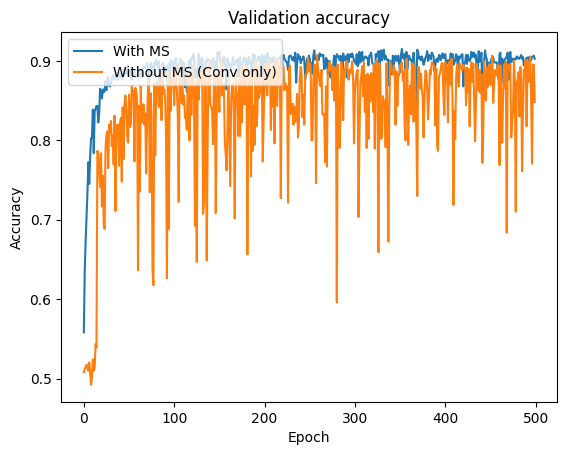

In [11]:
from matplotlib import pyplot as plt
plt.plot(history1.history['val_avg_accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['With MS', 'Without MS (Conv only)'], loc='upper left')
plt.show()